In [44]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.xgb_forecasting import XGBoostModel
from src.lstm_forecasting import LSTMTimeSeries
from sklearn.metrics import mean_squared_error
from src.preprocess import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

In [46]:
# Champs-Elysees
df_champs_lstm = pipeline(champs_elysees_df, window=3, fill_hours=True,fillna=True)
# fill_hours=True → add missing hourly timestamps to ensure continuous time sequences (important for LSTM)  
# fillna=True → fill missing (NaN) values in the existing data

# Sts peres
sts_peres_df = treat_nan_sts_peres(sts_peres_df) # sts_peres has some months missing in the middle, we decided to aggregate the data before and after the gap
df_sts_peres_xgb = pipeline(sts_peres_df,window=3,fill_hours=False,fillna=True)

# Convention
convention_df = treat_nan_convention(convention_df) # convention has a lot of missing data in the begining, we decided to only keep some data
df_convention_xgb = pipeline(convention_df,window=3,fill_hours=False,fillna=True)

In [47]:
df_test_champs_2025, df_test_convention_2025, df_test_peres_2025 = create_test_dataset(df_champs_lstm,df_convention_xgb,df_sts_peres_xgb)


after examination :

    Champs-elysees --> LSTM

    convention --> xgb

    sts peres --> xgb

In [48]:
targets = ['Débit horaire', "Taux d'occupation"]

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb_sts_peres = df_sts_peres_xgb.copy()

lags_hours = [72, 168]  # 3 days and 1 week lags
df_xgb_sts_peres, features_xgb_sts_peres = create_lag_features(df_xgb_sts_peres, targets=targets, lags_hours=lags_hours)

features_xgb_sts_peres += features_xgb


xgb_model_sts_peres = XGBoostModel(df_xgb_sts_peres, features_xgb_sts_peres, targets)
xgb_model_sts_peres.full_train()


Full training completed on all data.


{'Débit horaire': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 "Taux d'occupation": XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
      

In [49]:
X_test=df_test_peres_2025[features_xgb_sts_peres]
y_pred=xgb_model_sts_peres.predict_final(X_test)
print(y_pred)

    pred_Débit horaire  pred_Taux d'occupation
0           431.582794                6.130137
1           442.594177                5.852811
2           389.722931                5.179189
3           327.225220                4.155252
4           234.893509                2.901255
5           171.646683                2.347947
6           141.106186                1.938719
7           137.654037                1.885226
8           137.700638                2.184331
9           161.468430                2.862765
10          253.254211                3.990453
11          324.222504                5.718586
12          349.951538                7.036371
13          441.290100                7.267732
14          475.749725                7.957772
15          533.928345                9.137341
16          577.421875                9.321200
17          605.470642               10.022476
18          642.095215               11.032804
19          621.538818                9.934517
20          5

In [50]:

# --- Créer le DataFrame date/heure pour 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00", "2025-11-11 23:00", freq="H")

# --- Convertir y_pred en DataFrame ---
y_pred_df = pd.DataFrame(y_pred)
# --- Ajouter la colonne datetime ---
df_output = pd.DataFrame({
    'arc': 'Saint-Pères',  # changer selon le site si nécessaire
    'datetime': date_range,
    'debit_horaire': y_pred_df['pred_Débit horaire'],
    'taux_occupation': y_pred_df["pred_Taux d'occupation"]
})

# --- Formater la colonne datetime comme indiqué ---
df_output['datetime'] = df_output['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Exporter en CSV ---
df_output.to_csv("output_bison_fûté.csv", index=False)


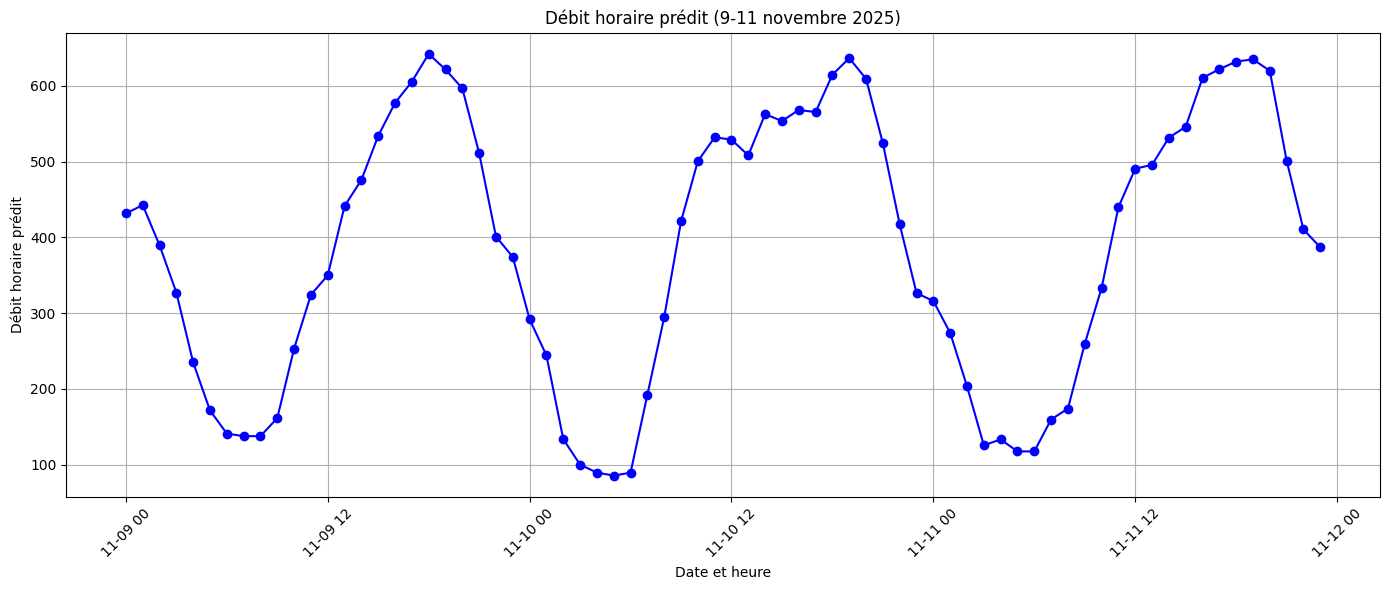

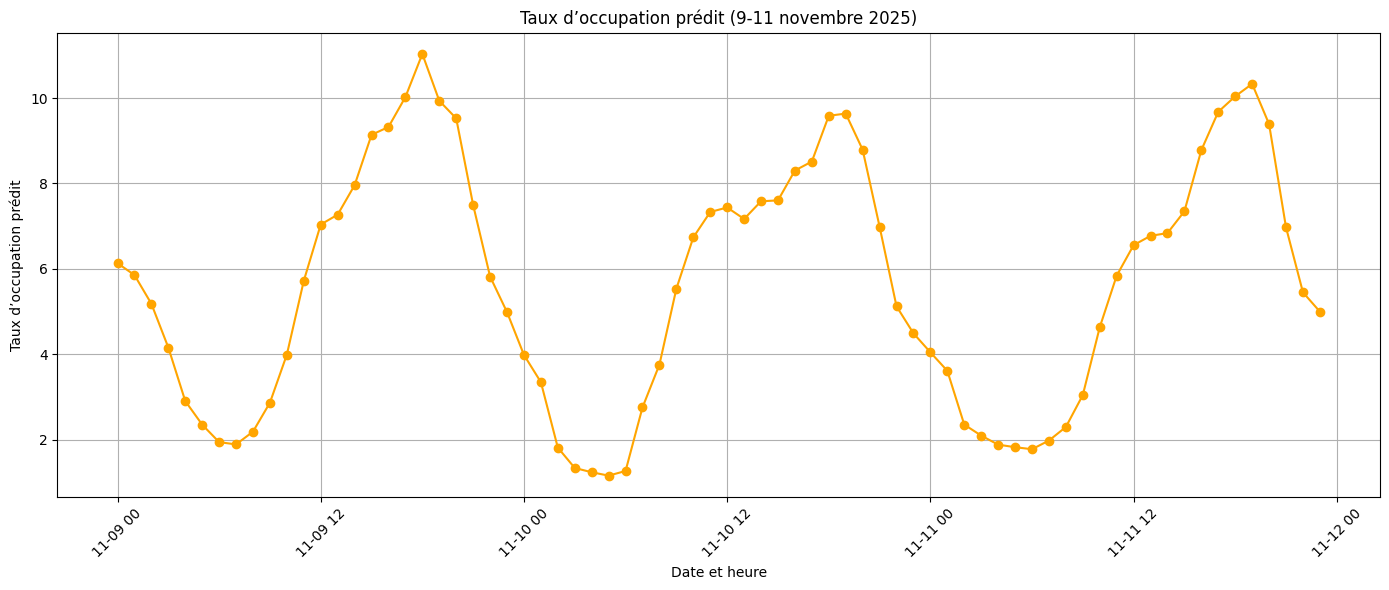

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Ajouter les prédictions y_pred ---
df_plot = pd.concat([df_plot.reset_index(drop=True), 
                     y_pred[['pred_Débit horaire', 'pred_Taux d\'occupation']].reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
targets = ['Débit horaire', "Taux d'occupation"]

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb_convention = df_convention_xgb.copy()

lags_hours = [72, 168]  # 3 days and 1 week lags
df_xgb_convention, features_xgb_convention = create_lag_features(df_xgb_convention, targets=targets, lags_hours=lags_hours)

features_xgb_convention += features_xgb


xgb_model_convention = XGBoostModel(df_xgb_convention, features_xgb_convention, targets)
xgb_model_convention.full_train()

Full training completed on all data.


{'Débit horaire': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 "Taux d'occupation": XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
      

In [53]:
X_test=df_test_convention_2025[features_xgb_convention]
y_pred=xgb_model_convention.predict_final(X_test)
print(y_pred)

    pred_Débit horaire  pred_Taux d'occupation
0           304.052521                2.133024
1           286.461029                1.861876
2           245.002502                1.669941
3           198.880508                1.365265
4           153.020584                0.932355
5           123.042625                0.842746
6           135.926819                0.902107
7           140.145874                1.045176
8           150.708740                1.184077
9           166.393799                1.406029
10          262.845398                2.078372
11          357.320099                2.470277
12          412.668488                2.853626
13          486.947235                3.396832
14          533.299194                3.616098
15          552.481140                4.203020
16          570.837280                4.295167
17          581.700623                4.567873
18          574.880615                4.302231
19          564.464966                4.194433
20          5

In [54]:
# --- Lire le CSV existant (Saint-Pères déjà présent) ---
df_output = pd.read_csv("output_bison_fûté.csv")

# --- Créer le DataFrame pour Convention ---
y_pred_convention_df = pd.DataFrame(y_pred)  # tes prédictions pour Convention

date_range_convention = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")

df_convention = pd.DataFrame({
    'arc': 'Convention',
    'datetime': date_range_convention,
    'debit_horaire': y_pred_convention_df['pred_Débit horaire'],
    'taux_occupation': y_pred_convention_df["pred_Taux d'occupation"]
})

# --- Formater la colonne datetime ---
df_convention['datetime'] = df_convention['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Concaténer les deux DataFrames (Saint-Pères + Convention) ---
df_output = pd.concat([df_output, df_convention], axis=0).reset_index(drop=True)

# --- Réexporter en CSV ---
df_output.to_csv("output_bison_fûté.csv", index=False)


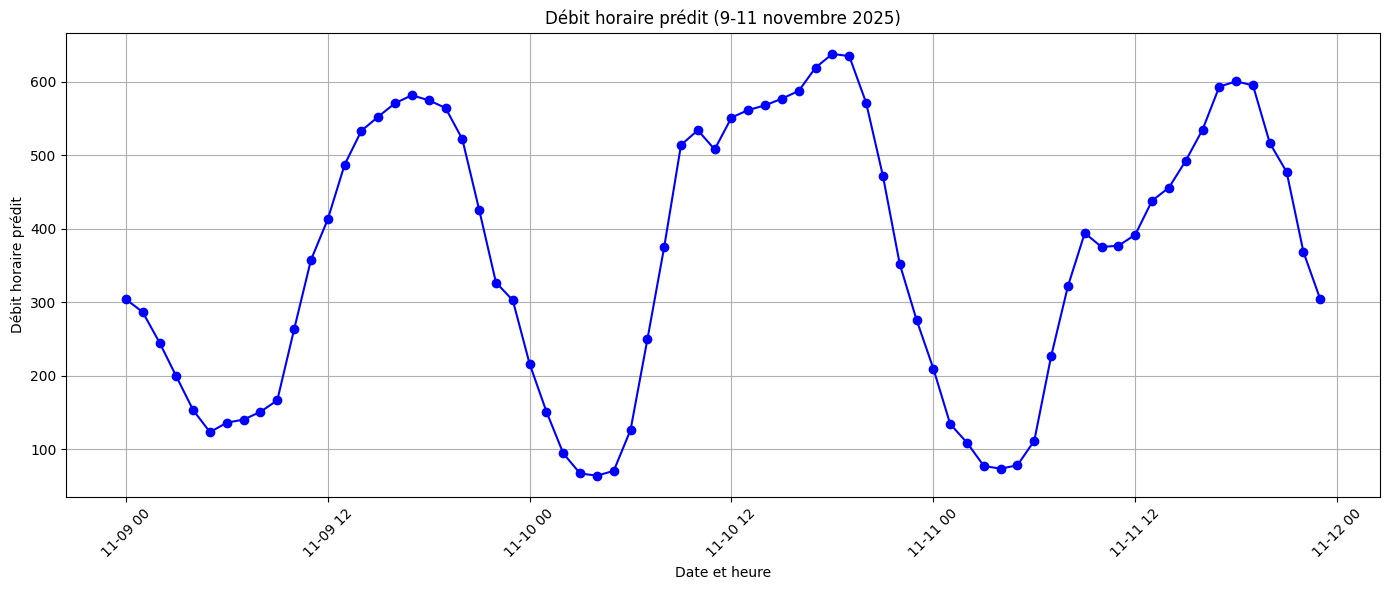

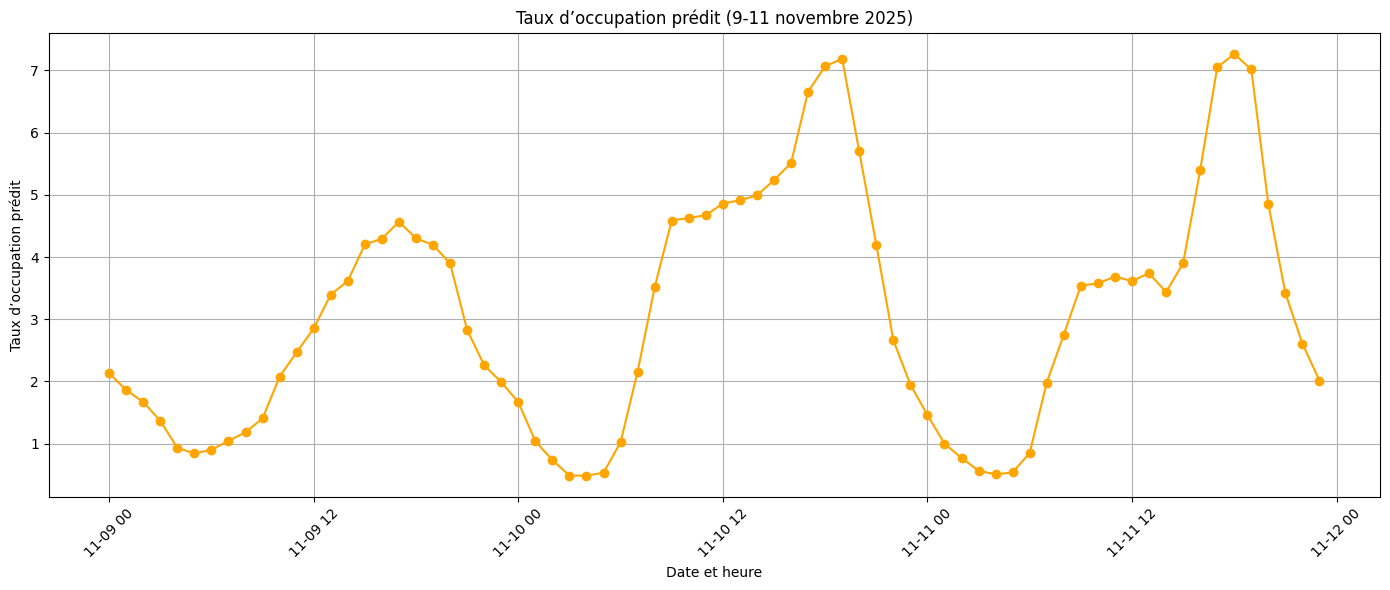

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Ajouter les prédictions y_pred ---
df_plot = pd.concat([df_plot.reset_index(drop=True), 
                     y_pred[['pred_Débit horaire', 'pred_Taux d\'occupation']].reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
targets = ['Débit horaire', "Taux d'occupation"]

features_champs = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

In [57]:
final_eval_size = 72
seq_length = 168

train_df_champs = df_champs_lstm.copy()

lstm_model_champs = LSTMTimeSeries(
    features=features_champs,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

lstm_model_champs.train_final(train_df_champs, epochs=1, batch_size=32)

295/295 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - loss: 0.5556 - mae: 0.5428 - mape: 207.4592


In [58]:
len(features_champs)

21

In [59]:
# Extraire les 168 dernières heures de train pour initier la séquence
last_train_seq_df = train_df_champs[features_champs].iloc[-168:].copy()

# Vérification
print(last_train_seq_df.shape)  # doit être (168, n_features)

# Appel de la prédiction
y_pred = lstm_model_champs.predict(last_train_seq_df)  # la méthode s'occupe du reshape
print(y_pred)  # devrait être (72, n_targets)


(168, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
[[812.6761     16.305931 ]
 [792.9034     15.450262 ]
 [674.8206     12.848895 ]
 [608.7305     10.475881 ]
 [521.8071      9.234354 ]
 [538.79395     8.143827 ]
 [458.3128      6.314817 ]
 [444.4411      8.363418 ]
 [542.9181      9.250373 ]
 [550.8636     10.109783 ]
 [642.0038     11.060437 ]
 [716.0194     12.914357 ]
 [822.5648     16.620264 ]
 [838.6356     17.14784  ]
 [831.0573     21.82271  ]
 [881.4956     21.933554 ]
 [857.65356    22.33483  ]
 [865.04987    22.194387 ]
 [868.27313    22.214691 ]
 [823.49634    22.491552 ]
 [934.54596    22.759527 ]
 [873.2657     21.27185  ]
 [820.5385     18.749834 ]
 [887.8297     17.567495 ]
 [735.9111     15.564151 ]
 [710.2085     12.704896 ]
 [629.3675     10.91554  ]
 [561.27185     9.31025  ]
 [479.321       7.922322 ]
 [392.6729      6.1774497]
 [377.83643     4.7095456]
 [382.75525     5.181935 ]
 [486.17776     6.8557725]
 [547.368       8.210326 ]
 [655.3069      9.572596 ]
 [729.

In [60]:
df_output = pd.read_csv("output_bison_fûté.csv")


# --- Créer le DataFrame pour Champs-Élysées ---
date_range_champs = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")

df_champs = pd.DataFrame({
    'arc': 'Champs-Elysées',
    'datetime': date_range_champs,
    'debit_horaire': y_pred[:,0],
    'taux_occupation': y_pred[:,1]
})

# --- Formater la colonne datetime ---
df_champs['datetime'] = df_champs['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Ajouter au CSV existant ---
df_output = pd.concat([df_output, df_champs], axis=0).reset_index(drop=True)

# --- Réexporter ---
df_output.to_csv("output_bison_fûté.csv", index=False)


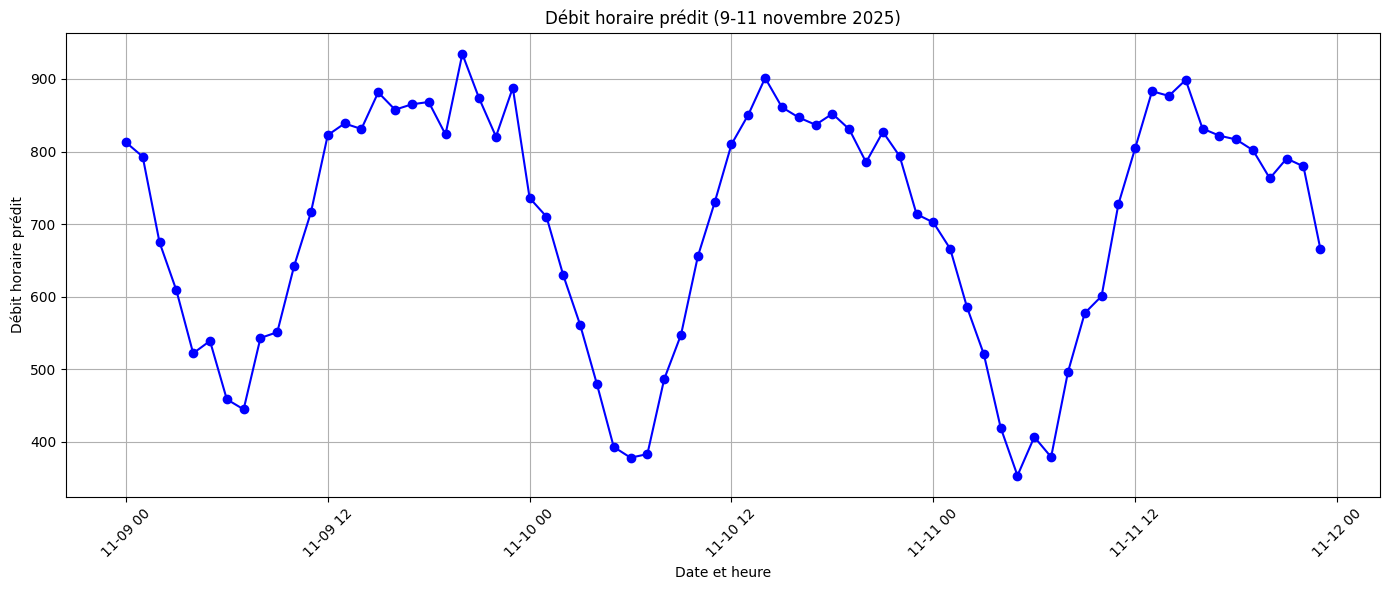

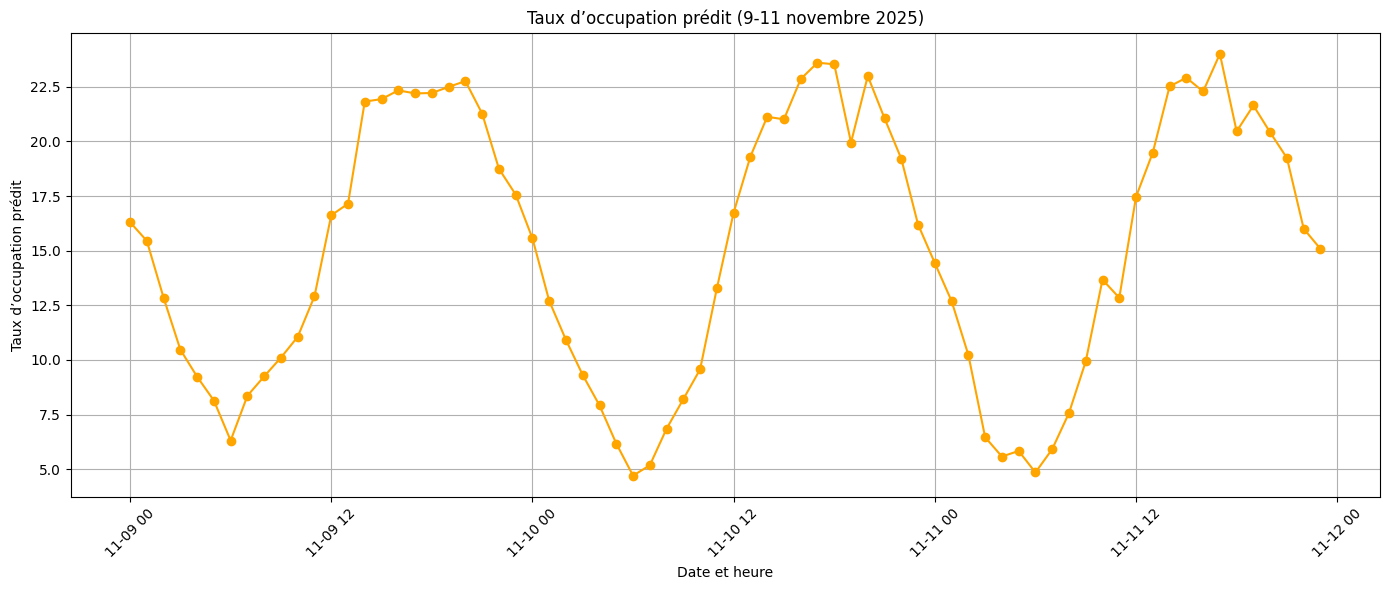

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Convertir y_pred en DataFrame et ajouter au df_plot ---
y_pred_df = pd.DataFrame(y_pred, columns=['pred_Débit horaire', 'pred_Taux d\'occupation'])
df_plot = pd.concat([df_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Verify CSV

In [66]:
from datetime import datetime
from pathlib import Path

def test_format_and_export_output(output_df, output_directory, name_of_the_group):
    output_columns = {
        "arc": object,
        "datetime": object,
        "debit_horaire": float,
        "taux_occupation": float
    }

    # 1. Check relevant columns are in output dataframe
    assert sorted(list(output_df.columns)) == list(output_columns.keys()), \
        "Some columns are missing or unnecessary columns are in output"

    # 2. Check types
    for col, col_type in output_columns.items():
        assert output_df[col].dtype == col_type, f"Column {col} does not have type {col_type}"

    # 3. Check datetime string has right format
    try:
        output_df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M"))
    except ValueError as e:
        raise e

    # 4. Check `arc` columns has right values
    expected_arcs = ["Champs-Elysées", "Convention", "Saint-Pères"]
    assert sorted(list(output_df["arc"].unique())) == expected_arcs, \
        "Output does not have expected unique values for column `arc`"

    # 5. Check dataframe has right number of rows
    assert output_df.shape[0] == 216, f"Expected number of rows is 216, output has {output_df.shape[0]}"

    # 6. Export output
    output_path = Path(output_directory) / f"output_{name_of_the_group}.csv"
    print(f"[SAVE OUTPUT] Saving output here: {output_path}")
    output_df[list(output_columns.keys())].to_csv(output_path, sep=";",index=False)



my_output=pd.read_csv("output_bison_fûté.csv",sep=";")

test_format_and_export_output(
    output_df=my_output,
    output_directory=".",  # le dossier courant
    name_of_the_group="bison_fûté"
)


[SAVE OUTPUT] Saving output here: output_bison_fûté.csv
